In [23]:
import jax
import jax.numpy as jnp
import numpy as np
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

# Sample MCMC chains in parallel

https://github.com/blackjax-devs/blackjax/blob/main/notebooks/Introduction.ipynb


## Setup

In [37]:
pip install blackjax

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 48 kB 3.5 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [38]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax.hmc as hmc
import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

## Model

In [43]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

def potential_fn(loc, scale, observed=observed):
    """Univariate Normal"""
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return -jnp.sum(logpdf)


potential = lambda x: potential_fn(**x)

initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = hmc.new_state(initial_position, potential)
print(initial_state)

inv_mass_matrix = np.array([0.5, 0.5])
num_integration_steps = 60
step_size = 1e-3





HMCState(position={'loc': 1.0, 'scale': 2.0}, potential_energy=DeviceArray(63537.625, dtype=float32), potential_energy_grad={'loc': DeviceArray(-2262.4763, dtype=float32, weak_type=True), 'scale': DeviceArray(-61425.547, dtype=float32, weak_type=True)})


## Single chain

In [ ]:
hmc_kernel = hmc.kernel(potential, step_size, inv_mass_matrix, num_integration_steps)
hmc_kernel = jax.jit(hmc_kernel)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [41]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 989 ms, sys: 0 ns, total: 989 ms
Wall time: 4.34 s


(10000,)


Text(0, 0.5, 'scale')

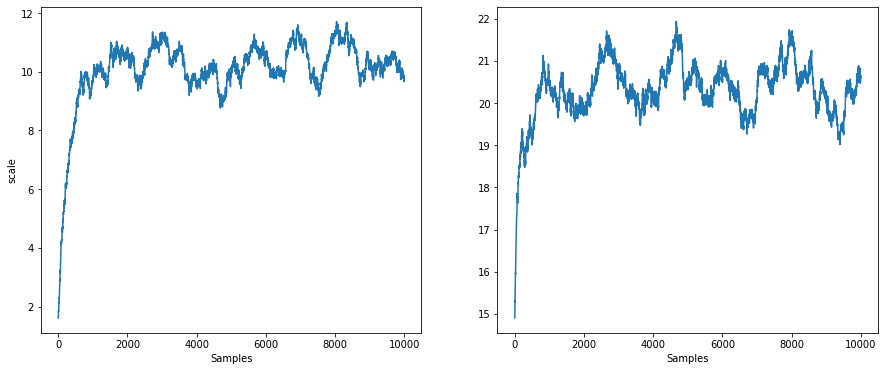

In [42]:

print(loc_samples.shape)

fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax.set_ylabel("scale")

## Multiple chains (VMAP)

In [45]:


def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [46]:

%%time

num_chains = 40
initial_positions = {"loc": np.ones(num_chains), "scale": 2.0 * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(
    initial_positions, potential
)

states = inference_loop_multiple_chains(rng_key, hmc_kernel, initial_states, 2_000, num_chains)
states.position["loc"].block_until_ready()

print(states.position["loc"].shape)

(2000, 40)
CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 2.17 s


## Multiple chains (PMAP)

In [48]:
def inference_loop_pmap(
    rng_key, kernel, initial_state, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.pmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [49]:
%%time

num_chains = 40
initial_positions = {"loc": np.ones(num_chains), "scale": 2.0 * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(
    initial_positions, potential
)

states = inference_loop_pmap(rng_key, hmc_kernel, initial_states, 2_000, num_chains)
states.position["loc"].block_until_ready()

print(states.position["loc"].shape)

ValueError: compiling a primitive computation `scan` that requires 40 replicas, but only 8 XLA devices are available on backend tpu.